In [1]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt

/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


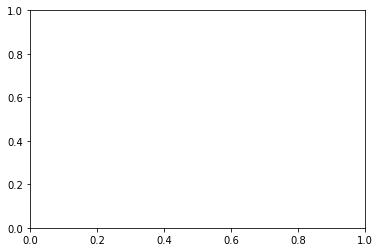

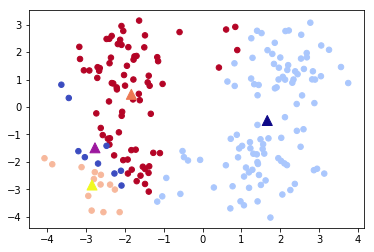

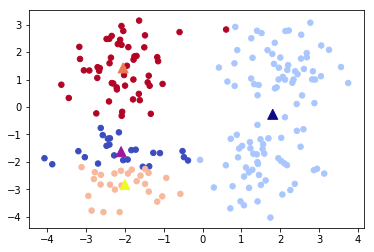

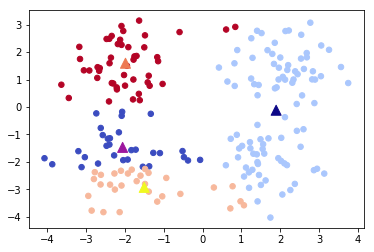

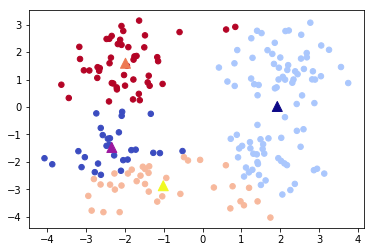

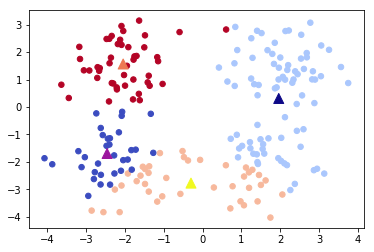

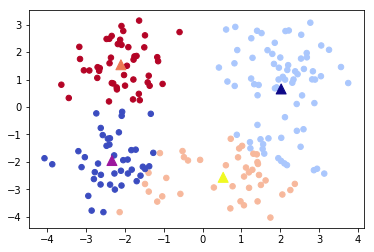

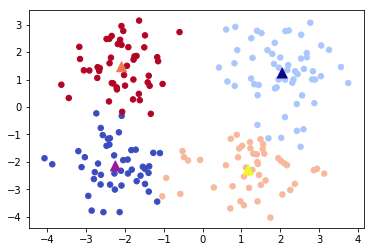

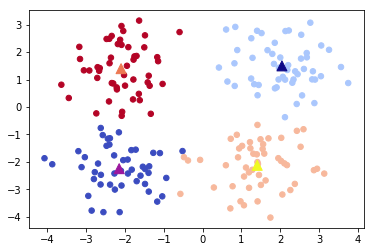

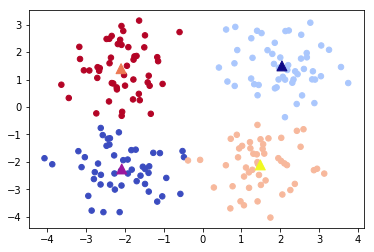

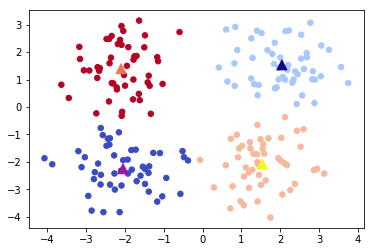

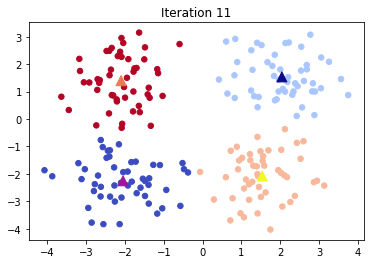

In [34]:
DATA_TYPE = "blobs"
if DATA_TYPE == "circle":
    K = 2
    data, features = make_circles(n_samples=200, shuffle=True, noise=0.01, factor=0.4)
else:
    K = 4
    centers = [(-2, -2), (-2, 1.5), (1.5, -2), (2, 1.5)]
    data, features = make_blobs(n_samples=200,
                               centers=centers,
                               n_features=2,
                               cluster_std=0.8,
                               shuffle=False,
                               random_state=1002)
    points = tf.Variable(data)
    N = points.shape[0].value
    cluster_assignments = tf.Variable(tf.zeros([N], dtype=tf.int64))
    centroids = tf.Variable(tf.slice(points.initialized_value(), [0, 0], [K, 2]))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())  
        tmp_centroids = tf.tile(centroids, [N, 1])
        tmp_points = tf.tile(points, [1, K])
        rep_centroids = tf.reshape(tmp_centroids, [N, K, 2])
        rep_points = tf.reshape(tmp_points, [N, K, 2])

        sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids), axis=2)
        new_assignments = tf.argmin(sum_squares, axis=1)
        did_assignments_change = tf.reduce_any(tf.not_equal(cluster_assignments, new_assignments))
        ##给定簇标注，计算簇心
        def bucket_mean(data, bucket_ids, num_buckets):
            total = tf.unsorted_segment_sum(data, bucket_ids, num_buckets)
            count = tf.unsorted_segment_sum(tf.ones_like(data), bucket_ids, num_buckets)
            return total / count
        new_centroids = bucket_mean(points, new_assignments, K)
        with tf.control_dependencies([did_assignments_change]):
            do_updates = tf.group(centroids.assign(new_centroids),
                                 cluster_assignments.assign(new_assignments))
        changed = True
        iters = 0
        MAX_ITERS = 100
        fig, ax = plt.subplots()
        if (DATA_TYPE == "blobs"):
            color_indexes = [2, 1, 4, 3]
        else:
            color_indexes = [2, 1]
        while changed and iters < MAX_ITERS:
            fig, ax = plt.subplots()
            iters += 1
            [changed, _] = sess.run([did_assignments_change, do_updates])
            [centers, assignments] = sess.run([centroids, cluster_assignments])
            data = sess.run(points)
            ax.scatter(data[:, 0], 
                       data[:, 1], 
                       marker="o", 
                       s=30, 
                       c=assignments, 
                       cmap=plt.cm.coolwarm)
            ax.scatter(centers[:, 0], 
                       centers[:, 1], 
                       marker="^", 
                       s=100, 
                       c=color_indexes, 
                       cmap=plt.cm.plasma)

        ax.set_title("Iteration " + str(iters))

In [4]:
t = tf.constant([[[1, 1, 1], [2, 2, 2]],
                 [[3, 3, 3], [4, 4, 4]],
                 [[5, 5, 5], [6, 6, 6]]])

In [13]:
tf.slice(t, [1, 0, 0], [1, 1, 3])

<tf.Tensor 'Slice_8:0' shape=(1, 1, 3) dtype=int32>

In [28]:
t = tf.constant(np.array([[True,  True], [False, False], [True, False]]))
b = tf.reduce_any(t, 1)
tf.Session().run(b)

array([ True, False,  True])